<a href="https://colab.research.google.com/github/Siddhi1604/22IT084-Summer-Internship-Sem-7/blob/main/22It084_Internship_Week_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 — Advanced Churn Analysis (Explanation & Report)



## 1. Setup (Packages)

The code expects these packages :

```bash
!pip install -q kagglehub shap imbalanced-learn xgboost
```

Key imports used: `pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn` (modeling, preprocessing, metrics), `imblearn.SMOTE`, `shap`, `kagglehub` (dataset download helper).

> Note: `kagglehub.dataset_download` is used to programmatically download the dataset into the runtime; ensure you have configured Kaggle credentials or that the dataset is public.

---

## 2. Data ingestion & robust CSV reading

**Problem addressed:** datasets downloaded from real-world sources can have inconsistent delimiters or encoding issues.

**Approach implemented:**

1. Use `kagglehub.dataset_download("rodsaldanha/arketing-campaign")` to download files and then search for `.csv` files.
2. `robust_read_csv(fp)` tries common separators (`;`, `,`, `\t`) and falls back to `csv.Sniffer()` if initial attempts fail.
3. If the file is loaded as a single column, there is a fallback re-read using `sep=';'`.

This helps avoid failures due to delimiter/encoding mismatch.

---

## 3. Basic cleaning

Steps performed:

- Strip whitespace from column names (`df.columns = [c.strip() for c in df.columns]`).
- Drop rows that are entirely empty (`df.dropna(how="all")`).
- Convert many expected numeric columns using `pd.to_numeric(..., errors='coerce')` so non-numeric garbage becomes `NaN` that can be handled later.
- Parse `Dt_Customer` into `datetime` if present.
- Drop rows missing core fields (e.g., `Income`, `Recency`) since these are essential for modeling.

**Why:** Ensures that later steps (feature engineering / model training) have correct dtypes and non-trivial sample size.

---

## 4. Feature engineering

Created features:

- `total_spent` — sum of all `Mnt*` (spend) columns found in the dataset.
- `Age` — derived from `Year_Birth` (using 2025 as reference year in code).
- `days_since_enrollment` — difference between the latest `Dt_Customer` and each customer's `Dt_Customer` (if `Dt_Customer` exists).
- `frequency` — sum of purchase count columns (e.g., `NumWebPurchases`, `NumCatalogPurchases`, `NumStorePurchases`).
- `CLTV_proxy` — a simple proxy for Customer Lifetime Value computed as `total_spent * max(frequency,1)`.

These are sensible features for churn analysis: recency, frequency, monetary (RFM) style.

---

## 5. Churn target construction

The code builds a **robust binary churn label** using 3 rules (and combines them with OR):

1. `churn_resp`: If `Response` exists and equals 0 → mark churn (assumes `Response==1` means active/positive)
2. `churn_inactive`: If `days_since_enrollment` > 730 days (2 years) → mark churn
3. `churn_low_spend`: If `total_spent` < median(total\_spent) → mark churn

Final label: `churn = (churn_resp == 1) | (churn_inactive == 1) | (churn_low_spend == 1)`

**Fallbacks:**

- If the combined rule yields a single-class target, code uses a `total_spent` quantile (35th percentile) to create a fallback churn label.

**Why:** Real-world datasets often lack a clean churn column. Multiple proxy rules increase the chance of producing a meaningful binary target for supervised learning.

---

## 6. Feature selection for modeling

Candidate numeric features in the code:

- `Age`, `Income`, `Kidhome`, `Teenhome`, `Recency`, `NumWebVisitsMonth`, `NumDealsPurchases`, `frequency`, `total_spent`, `days_since_enrollment`

Only features present in the dataset are used. If fewer than 4 features are found, the code raises an error to avoid weak models.

---

## 7. Train-test split & balancing

- Split: `train_test_split(..., test_size=0.2, stratify=y, random_state=42)` ensures class distribution is preserved in the test set.
- Balancing: `SMOTE(random_state=42)` is applied to the training set to synthetically oversample the minority class.
- Scaling: `StandardScaler` fitted on the resampled training data; transformed train/test sets for model input.

**Why:** Class imbalance commonly exists in churn modeling; balancing helps classifiers learn a better decision boundary.

---

## 8. Modeling: Random Forest

- Model used: `RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)` trained on scaled, balanced data.
- Predictions: both class labels (`predict`) and probabilities (`predict_proba`) are produced for the test set.

**Metrics shown:**

- `classification_report` (precision, recall, f1-score)
- `ROC AUC` (probabilistic separation ability)
- Confusion matrix heatmap
- ROC curve plot

These provide both class-level and probabilistic model performance.

---

## 9. Explainability: SHAP

- Uses `shap.TreeExplainer(rf)` and computes SHAP values with `check_additivity=False` (to avoid `ExplainerError` with scaled arrays or sklearn wrappers).
- Displays SHAP bar summary and beeswarm plots to surface global feature importance and per-sample impact.
- Tries to render a `dependence_plot` for the top feature.

**Why:** SHAP provides model-agnostic explanations and helps interpret what drives churn predictions (e.g., recency, frequency, spend).

**Notes:** SHAP visualizations open matplotlib windows in Colab. They may take a few seconds to compute for medium-sized datasets.

---

## 10. Partial Dependence Plots (PDP)

- Uses `sklearn.inspection.PartialDependenceDisplay.from_estimator` wrapped in a pipeline reusing the `scaler` and `rf` objects.
- Plots PDPs for the top two features (based on SHAP importance) to understand marginal effects.

**Why:** PDPs let you see how predicted churn probability changes as a single feature varies, holding others average.

---

## 11. Customer segmentation (KMeans)

- Fits `KMeans(n_clusters=4)` on a separately scaled version of the entire feature set and assigns cluster labels to `df["cluster"]`.
- Computes cluster-level aggregates: average predicted churn probability (`churn_proba`), actual churn rate, average spend, and customer counts.
- Produces a barplot of average predicted churn probability by cluster.

**Why:** Segmentation helps prioritize interventions (e.g., cluster(s) with high churn\_proba & high value deserve retention budget).

---

## 12. RFM snapshots (dynamic)

- If `Dt_Customer` exists, code builds snapshots every 180 days between earliest and latest `Dt_Customer`.
- For each snapshot it computes RFM (`RecencyDays`, `Frequency`, `Monetary`) and clusters customers into 3 RFM segments using KMeans.
- Aggregates median RFM values and record counts per segment across snapshots and concatenates into `rfm_all`.

**Why:** Rolling RFM snapshots show how customer segments evolve over time — useful for time-aware retention strategies.

---

## 13. Time-based cross-validation

- Uses `TimeSeriesSplit(n_splits=5)` on data ordered by `Dt_Customer` (or index if `Dt_Customer` missing).
- For each fold: balance the training slice with SMOTE, scale, train a RandomForest, and compute ROC AUC on the test slice.
- Reports AUC per fold and the average AUC.

**Why:** Standard random CV can leak time-dependent signals. TimeSeriesSplit evaluates model stability across time.

---

## 14. Outputs & artifacts for reporting

The script saves the following CSVs for downstream reporting (Power BI / PowerPoint / stakeholder sharing):

- `week6_cluster_summary.csv` — cluster-level churn and spend summary.
- `week6_rfm_snapshots.csv` — RFM snapshot table across snapshot dates (if snapshots were created).

Also, SHAP plots, PDPs, confusion matrix, ROC curve, and CV AUC scores are displayed during the run for quick iteration.

---

## 15. Reproducibility & runtime notes

- `random_state=42` is used across SMOTE, train/test split, KMeans, and RandomForest to ensure reproducible outputs.
- The code uses the **current year 2025** to compute `Age` — update that hard-coded value if you want a relative computation (e.g., `pd.Timestamp.now().year`).
- SHAP computations and model training may be time/CPU intensive on large datasets. Consider sampling or using fewer estimators for quick iterations.

---

## 16. Suggestions & enhancements

1. **Feature enrichment:** include RFM ratios, time-since-last-purchase buckets, product-category-level features, or channel engagement features.
2. **Hyperparameter tuning:** wrap the RF inside `RandomizedSearchCV` or `Optuna` for better predictive performance.
3. **Calibration:** check probability calibration (e.g., `CalibratedClassifierCV`) if churn probability will be used for direct business actions.
4. **Threshold optimization:** instead of default 0.5, optimize an operating threshold using business metrics (cost of false positives vs false negatives).
5. **Model alternatives:** try gradient boosting models (XGBoost / LightGBM / CatBoost) — they often perform better and have fast native SHAP support.
6. **Productionization:** package the pipeline with `sklearn.pipeline.Pipeline`, persist scalers & model with `joblib`, and add a small scoring script for inference.

---

Path to dataset files: /kaggle/input/arketing-campaign
Found CSV: /kaggle/input/arketing-campaign/marketing_campaign.csv
Reading CSV with robust parsing...
Raw loaded shape: (2240, 29)
Columns (first 20): ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04       58       635  ...                  7             0   
1  2014-03-08       38        11  ...                  5             0   

   AcceptedCmp4  Accep

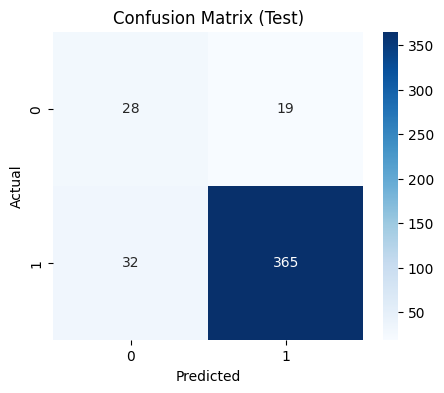

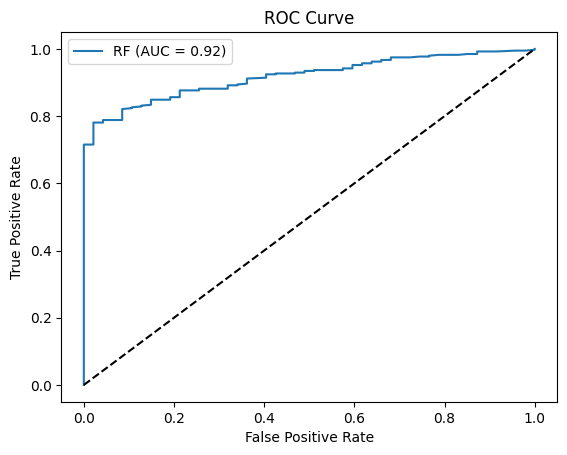


Computing SHAP values (may take a few seconds)...
SHAP summary (bar):


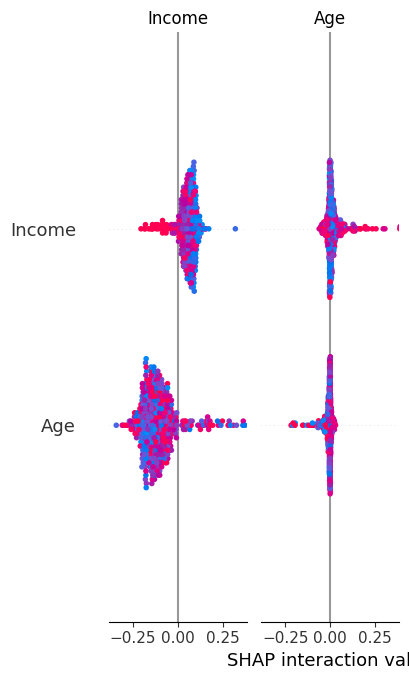

SHAP beeswarm:


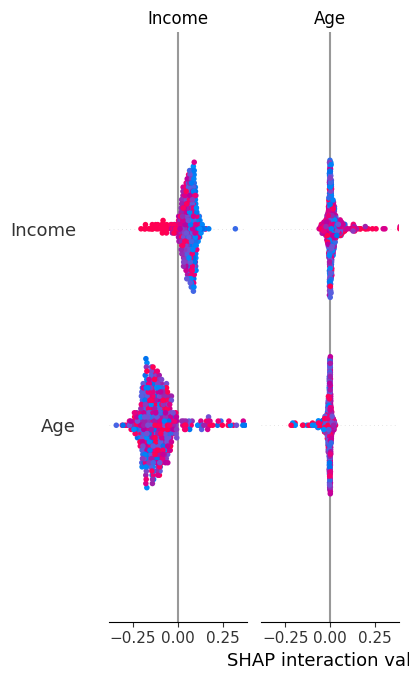

Could not render SHAP dependence plot: list index out of range
PDP features: ['Age', 'Income']


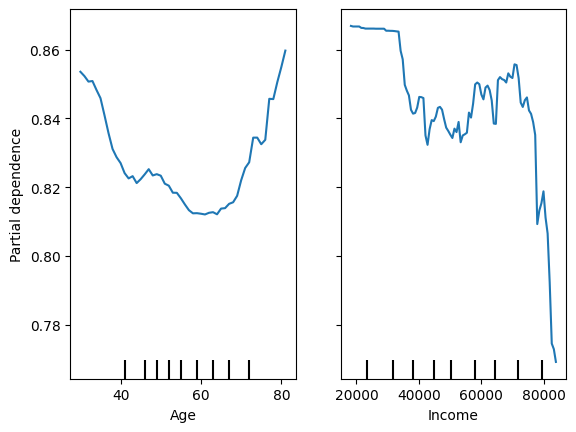


Running KMeans segmentation...
Cluster summary (avg churn_proba, churn_rate, avg_spend, count):


,cluster,churn_proba,churn,total_spent,count
0,0,0.996859,1.000000,122.232558,516
1,1,0.635999,0.729965,1325.637631,574
2,2,0.812006,0.868373,825.557587,547
3,3,0.980861,0.989637,120.398964,579


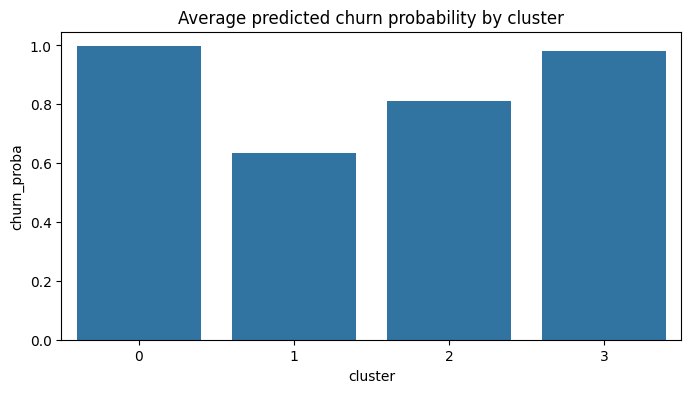


Creating RFM snapshots (every 180 days)...
RFM snapshots created: 12


,RFM_segment,RecencyDays,Frequency,Monetary,count,snapshot_date
0,0,7.0,10.0,246.0,33,2012-08-29
1,1,17.0,20.0,1396.0,47,2012-08-29
2,2,23.0,8.0,180.0,23,2012-08-29
3,0,107.0,6.0,103.0,309,2013-02-25
4,1,44.0,19.0,1001.0,174,2013-02-25



Time-based cross-validation (TimeSeriesSplit) ...
Fold 1 AUC: 0.8674
Fold 2 AUC: 0.8722
Fold 3 AUC: 0.9328
Fold 4 AUC: 0.9042
Fold 5 AUC: 0.9510
Time-based CV AUC scores: [np.float64(0.8674), np.float64(0.8722), np.float64(0.9328), np.float64(0.9042), np.float64(0.951)]
Average AUC: 0.9055
Saved: week6_cluster_summary.csv
Saved: week6_rfm_snapshots.csv

Week 6 pipeline complete. Key outputs:
- cluster_summary (week6_cluster_summary.csv)
- rfm snapshots (week6_rfm_snapshots.csv) [if created]
- SHAP plots, PDPs, and CV AUC scores displayed above.


In [ ]:
# =========================
# Week 6 — Advanced Churn Analysis (complete)
# =========================

# 0) Install required packages (uncomment if needed in Colab)
# !pip install -q kagglehub shap imbalanced-learn xgboost

# 1) Imports
import os, csv
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.inspection import PartialDependenceDisplay
from sklearn.pipeline import Pipeline as SKPipeline

from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

# 2) Download dataset via kagglehub and locate CSV
path = kagglehub.dataset_download("rodsaldanha/arketing-campaign")
print("Path to dataset files:", path)

files = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
if len(files) == 0:
    raise FileNotFoundError(f"No CSV found under {path}")
csv_path = os.path.join(path, files[0])
print("Found CSV:", csv_path)

# 3) Read CSV robustly (detect delimiter if necessary)
def robust_read_csv(fp):
    # Try common separators first
    for sep in [";", ",", "\t"]:
        try:
            df_try = pd.read_csv(fp, sep=sep, engine="python")
            # If read gives >1 column and common expected column names present, accept it
            if df_try.shape[1] > 1:
                return df_try
        except Exception:
            pass
    # fallback: sniff delimiter
    with open(fp, "r", encoding="utf-8", errors="replace") as f:
        sample = f.read(4096)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=";, \t")
        delim = dialect.delimiter
    except Exception:
        delim = ";"
    df = pd.read_csv(fp, sep=delim, engine="python")
    return df

print("Reading CSV with robust parsing...")
df = robust_read_csv(csv_path)
print("Raw loaded shape:", df.shape)
print("Columns (first 20):", list(df.columns)[:20])
print(df.head(2))

# 4) Basic cleaning & safe column name trim
df.columns = [c.strip() for c in df.columns]
df = df.dropna(how="all").copy()   # drop fully empty rows

# If file was loaded as single column (rare fallback), split rows by detected delimiter
if df.shape[1] == 1:
    print("Single-column read detected; attempting split by ';'...")
    df = pd.read_csv(csv_path, sep=";", engine="python")
    df.columns = [c.strip() for c in df.columns]
    print("After split shape:", df.shape)

# 5) Coerce numeric columns we will use
numeric_cols = ["Income","Recency","Year_Birth",
                "MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds",
                "NumWebPurchases","NumCatalogPurchases","NumStorePurchases","NumWebVisitsMonth",
                "NumDealsPurchases","Kidhome","Teenhome","Response"]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Parse Dt_Customer if present
if "Dt_Customer" in df.columns:
    df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], errors="coerce")

# 6) Drop rows missing core fields (Income and Recency are important)
core = [c for c in ["Income","Recency"] if c in df.columns]
if core:
    before = df.shape[0]
    df = df.dropna(subset=core)
    print(f"Dropped {before - df.shape[0]} rows missing {core}. New shape: {df.shape}")

# 7) Feature engineering
spend_cols = [c for c in ["MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds"] if c in df.columns]
if not spend_cols:
    raise RuntimeError("No spend columns (Mnt*) found — cannot proceed.")

df["total_spent"] = df[spend_cols].sum(axis=1)

if "Year_Birth" in df.columns:
    df["Age"] = 2025 - df["Year_Birth"]
else:
    df["Age"] = np.nan

if df["Dt_Customer"].notna().any():
    current_date = df["Dt_Customer"].max()
    df["days_since_enrollment"] = (current_date - df["Dt_Customer"]).dt.days
else:
    df["days_since_enrollment"] = np.nan

freq_cols = [c for c in ["NumWebPurchases","NumCatalogPurchases","NumStorePurchases"] if c in df.columns]
df["frequency"] = df[freq_cols].sum(axis=1) if freq_cols else 0
df["CLTV_proxy"] = df["total_spent"] * (df["frequency"].replace(0,1))

print("Feature engineering complete. Sample:")
print(df[["total_spent","frequency","CLTV_proxy"]].head())

# 8) Build robust churn target (ensures two classes)
# Primary: Response==0 -> churn (if Response exists)
df["churn_resp"] = 0
if "Response" in df.columns:
    df["churn_resp"] = df["Response"].apply(lambda x: 1 if (not pd.isna(x) and x == 0) else 0)

# Secondary: inactivity
df["churn_inactive"] = np.where(df["days_since_enrollment"] > 730, 1, 0)

# Tertiary: low spend
median_spend = df["total_spent"].median()
df["churn_low_spend"] = np.where(df["total_spent"] < median_spend, 1, 0)

# Combine (OR)
df["churn"] = np.where((df["churn_resp"]==1) | (df["churn_inactive"]==1) | (df["churn_low_spend"]==1), 1, 0)
print("Churn distribution after combined rule:\n", df["churn"].value_counts())

# Fallback if single-class
if df["churn"].nunique() == 1:
    cutoff = df["total_spent"].quantile(0.35)
    df["churn"] = np.where(df["total_spent"] <= cutoff, 1, 0)
    print("Fallback churn distribution:\n", df["churn"].value_counts())

if df["churn"].nunique() < 2:
    raise RuntimeError("Unable to create a valid binary churn target. Inspect dataset.")

# 9) Choose modeling features (numeric only, present in dataset)
candidate_features = ["Age","Income","Kidhome","Teenhome","Recency","NumWebVisitsMonth",
                      "NumDealsPurchases","frequency","total_spent","days_since_enrollment"]
features = [f for f in candidate_features if f in df.columns]
print("Modeling features chosen:", features)
if len(features) < 4:
    raise RuntimeError("Too few features for robust modeling. Found: " + str(features))

X = df[features].fillna(df[features].median())
y = df["churn"].astype(int)

# 10) Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train churn distribution:\n", y_train.value_counts())
print("Test churn distribution:\n", y_test.value_counts())

# 11) Balance training set with SMOTE, then scale
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

scaler = StandardScaler().fit(X_train_res)
X_train_res_scaled = scaler.transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
X_full_scaled_for_clustering = StandardScaler().fit_transform(X)  # separate scaler for clustering/segments

# 12) Train RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_res_scaled, y_train_res)

# 13) Predictions & metrics
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:,1]

print("\nClassification report (test):")
print(classification_report(y_test, y_pred))
print("ROC AUC (test):", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc_score(y_test,y_proba):.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 14) SHAP explainability (disable additivity check to avoid ExplainerError)
print("\nComputing SHAP values (may take a few seconds)...")
explainer = shap.TreeExplainer(rf)                 # use TreeExplainer for RF
shap_expl = explainer(X_test_scaled, check_additivity=False)  # Explanation object

# SHAP summary (bar)
print("SHAP summary (bar):")
shap.summary_plot(shap_expl, pd.DataFrame(X_test_scaled, columns=features), plot_type="bar", show=True)

# SHAP beeswarm
print("SHAP beeswarm:")
shap.summary_plot(shap_expl, pd.DataFrame(X_test_scaled, columns=features), show=True)

# SHAP dependence plot for top feature if available
try:
    shap_arr = np.abs(shap_expl.values).mean(axis=0)
    top_feat_idx = int(np.argmax(shap_arr))
    top_feat = features[top_feat_idx]
    print("Top SHAP feature:", top_feat)
    if top_feat in features:
        shap.dependence_plot(top_feat, shap_expl.values, pd.DataFrame(X_test_scaled, columns=features), interaction_index=None, show=True)
except Exception as e:
    print("Could not render SHAP dependence plot:", e)

# 15) Partial Dependence Plots for top 2 features
try:
    top2_idx = np.argsort(np.abs(shap_expl.values).mean(axis=0))[-2:][::-1]
    pdp_feats = [features[i] for i in top2_idx]
except Exception:
    pdp_feats = features[:2]

print("PDP features:", pdp_feats)
pdp_pipeline = SKPipeline([('scaler', scaler), ('rf', rf)])  # uses same fitted scaler & rf
PartialDependenceDisplay.from_estimator(pdp_pipeline, X_test, pdp_feats, feature_names=features)
plt.show()

# 16) KMeans segmentation + cluster-level churn summary
print("\nRunning KMeans segmentation...")
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_full_scaled_for_clustering)
df["cluster"] = cluster_labels

# churn probability on full dataset
df["churn_proba"] = rf.predict_proba(scaler.transform(X))[:,1]

cluster_summary = df.groupby("cluster").agg({
    "churn_proba":"mean",
    "churn":"mean",
    "total_spent":"mean",
    "ID":"count"
}).rename(columns={"ID":"count"}).reset_index()

print("Cluster summary (avg churn_proba, churn_rate, avg_spend, count):")
display(cluster_summary)

plt.figure(figsize=(8,4))
sns.barplot(x="cluster", y="churn_proba", data=cluster_summary)
plt.title("Average predicted churn probability by cluster")
plt.show()

# 17) Dynamic RFM snapshots (rolling windows)
print("\nCreating RFM snapshots (every 180 days)...")
rfm_snapshots = []
if df["Dt_Customer"].notna().any():
    min_date = df["Dt_Customer"].min()
    max_date = df["Dt_Customer"].max()
    snapshots = pd.date_range(min_date + pd.Timedelta(days=30), max_date, freq="180D")
    for snap in snapshots:
        snap_df = df[df["Dt_Customer"] <= snap].copy()
        if len(snap_df) < 50:
            continue
        snap_df["RecencyDays"] = (snap - snap_df["Dt_Customer"]).dt.days
        snap_df["Frequency"] = snap_df[freq_cols].sum(axis=1) if freq_cols else 0
        snap_df["Monetary"] = snap_df["total_spent"].fillna(0)
        rfm = snap_df[["RecencyDays","Frequency","Monetary"]].fillna(0)
        rfm_scaled = StandardScaler().fit_transform(rfm)
        rfm_labels = KMeans(n_clusters=3, random_state=42).fit_predict(rfm_scaled)
        snap_df["RFM_segment"] = rfm_labels
        rfm_summary = snap_df.groupby("RFM_segment").agg({
            "RecencyDays":"median",
            "Frequency":"median",
            "Monetary":"median",
            "ID":"count"
        }).rename(columns={"ID":"count"}).reset_index()
        rfm_summary["snapshot_date"] = snap
        rfm_snapshots.append(rfm_summary)
    if rfm_snapshots:
        rfm_all = pd.concat(rfm_snapshots, ignore_index=True)
        print("RFM snapshots created:", rfm_all.shape[0])
        display(rfm_all.head())
    else:
        print("Not enough data to create RFM snapshots.")
else:
    print("Dt_Customer not available — skipping RFM snapshots.")

# 18) Time-based cross-validation (TimeSeriesSplit)
print("\nTime-based cross-validation (TimeSeriesSplit) ...")
if df["Dt_Customer"].notna().any():
    order_idx = df.sort_values("Dt_Customer").index
else:
    order_idx = df.index

X_ord = X.loc[order_idx].reset_index(drop=True)
y_ord = y.loc[order_idx].reset_index(drop=True)

tscv = TimeSeriesSplit(n_splits=5)
auc_scores = []
fold = 1
for train_idx, test_idx in tscv.split(X_ord):
    X_tr, X_te = X_ord.iloc[train_idx], X_ord.iloc[test_idx]
    y_tr, y_te = y_ord.iloc[train_idx], y_ord.iloc[test_idx]
    # balance training fold
    X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    scaler_cv = StandardScaler().fit(X_tr_res)
    X_tr_s = scaler_cv.transform(X_tr_res)
    X_te_s = scaler_cv.transform(X_te)
    rf_cv = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_cv.fit(X_tr_s, y_tr_res)
    y_te_proba = rf_cv.predict_proba(X_te_s)[:,1]
    auc = roc_auc_score(y_te, y_te_proba)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")
    fold += 1

print("Time-based CV AUC scores:", [round(x,4) for x in auc_scores])
print("Average AUC:", round(np.mean(auc_scores),4))

# 19) Export artifacts for Power BI / reporting
cluster_summary.to_csv("week6_cluster_summary.csv", index=False)
print("Saved: week6_cluster_summary.csv")
if 'rfm_all' in locals():
    rfm_all.to_csv("week6_rfm_snapshots.csv", index=False)
    print("Saved: week6_rfm_snapshots.csv")

print("\nWeek 6 pipeline complete. Key outputs:")
print("- cluster_summary (week6_cluster_summary.csv)")
print("- rfm snapshots (week6_rfm_snapshots.csv) [if created]")
print("- SHAP plots, PDPs, and CV AUC scores displayed above.")